## Vlasiator - A Global Hybrid-Vlasov Simulation Model 
Vlasiator [@palmroth2018] is an open-source simulation software used to model the behavior of plasma in the Earth's magnetosphere, a region of space where the solar wind interacts with the Earth’s magnetic field. Vlasiator models collisionless space plasma dynamics by solving the 6-dimensional Vlasov equation, using a hybrid-Vlasov approach. It uses a 3D Cartesian grid in real space, with each cell storing another 3D Cartesian grid in velocity space. The velocity mesh contained in each spatial cell in the simulation domain has been represented so far by a sparse grid approach, fundamentally based on an associative container such as a key-value hashtable. Storing a 3D VDF at every spatial cells increases the memory requirements exponentially both during runtime and for storing purposes. Our proposal revolves around developing innovative solutions to compressing the VDFs during runtmime.

![title](images/egi.png)


## VDF Compression


### Let's read in a vdf from a sample file and see what that looks like.

In [2]:
import sys,os
# sys.path.append('/home/mjalho/analysator')
import tools as project_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.colors as colors
# plt.rcParams['figure.figsize'] = [7, 7]
import ctypes
import pyzfp,zlib
import mlp_compress

import pytools

Found population proton
Getting offsets for population proton
VDF shape = (50, 50, 50)


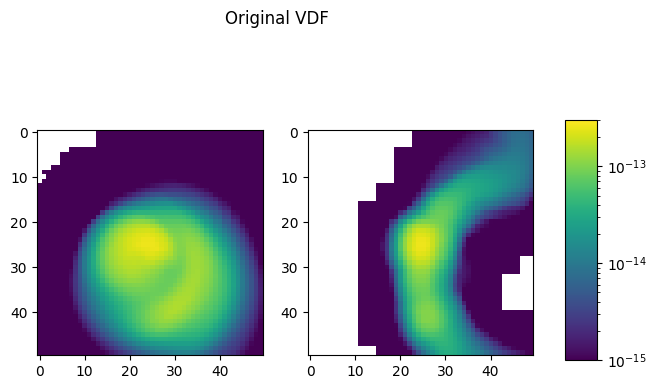

In [3]:
file="/home/kstppd/Desktop/bulk1.0001280.vlsv";cid=356780649;
#Read the VDF into a 3D uniform mesh and plot it
vdf=project_tools.extract_vdf(file,cid,25)
# np.save("sample_vdf.bin",np.array(vdf,dtype=np.double));
np.array(vdf,dtype=np.double).tofile("sample_vdf.bin")
nx,ny,nz=np.shape(vdf)
print(f"VDF shape = {np.shape(vdf)}")
fig,(ax1, ax2) = plt.subplots(1, 2)
cax = fig.add_axes([0.95,0.25,0.05,0.5])
im1 = ax1.imshow(vdf[:,:,nz//2],norm=colors.LogNorm(vmin=1e-15,vmax=3e-13))
im2 = ax2.imshow(vdf[:,ny//2,:],norm=colors.LogNorm(vmin=1e-15,vmax=3e-13))


fig.colorbar(im1, cax=cax)
fig.suptitle("Original VDF")
plt.show()

### The vdf shown above is sampled on a uniform 3D velocity mesh and contains 64bit floating point numbers that represent the phase space density. We can calculate the total size of this VDF is bytes using ```sys.getsizeof(vdf)```.

In [4]:
vdf_mem=sys.getsizeof(vdf)
num_stored_elements=len(vdf[vdf>1e-15])
print(f"VDF takes {vdf_mem} B.")

VDF takes 500144 B.


### Now in Vlasiator we have countlesss VDFs since there is one per spatial cell. It would be great if we could compress them efficiently. We can try to do so by using zlib which is a form of lossless compression.

Achieved compression ratio using zlib= 1.54.


/home/kstppd/dev/asterix/tools.py:90: RuntimeWarning: divide by zero encountered in divide
  im6 = ax[1,2].imshow((lapl_0**2/a)[slicer2d], norm=colors.LogNorm(vmin=1e-17,vmax=1e-13),cmap='seismic')
/home/kstppd/dev/asterix/tools.py:90: RuntimeWarning: invalid value encountered in divide
  im6 = ax[1,2].imshow((lapl_0**2/a)[slicer2d], norm=colors.LogNorm(vmin=1e-17,vmax=1e-13),cmap='seismic')


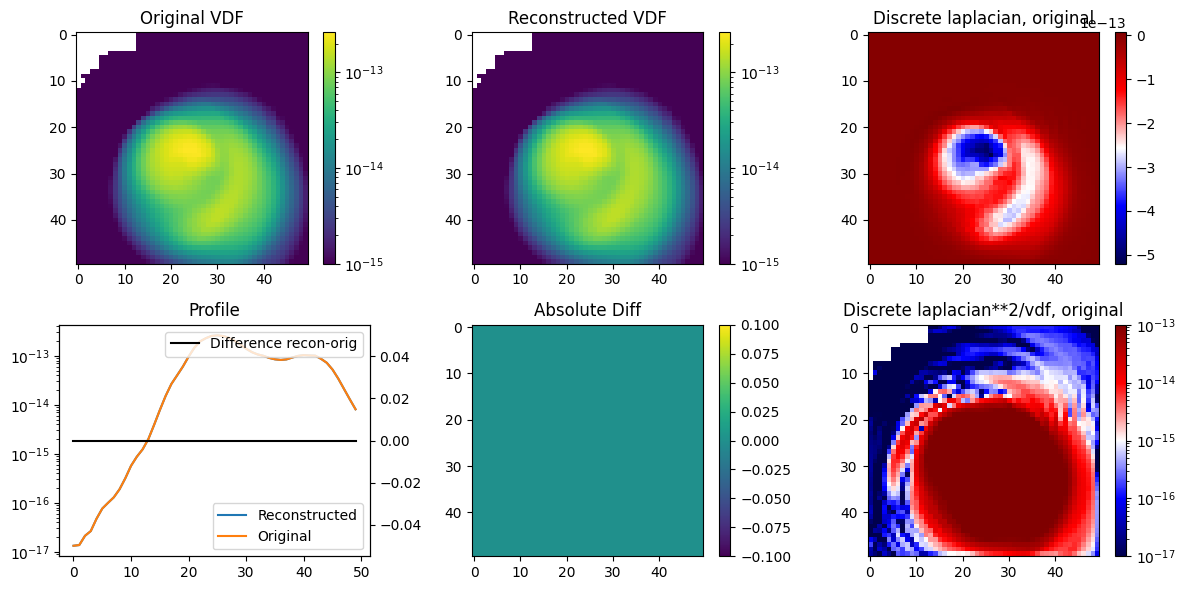

Moment Stats (R,Vm)= (0.0, 0.0) %.
L1,L2 rNorms= (0.0, 0.0).


In [5]:
compressed_vdf = zlib.compress(vdf)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zlib= {round(compression_ratio,2)}.")
decompressed_vdf = zlib.decompress(compressed_vdf)
recon = np.frombuffer(decompressed_vdf, dtype=vdf.dtype).reshape(vdf.shape)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We can use a lossy compression method like zfp[@zfp] to get even higher compression ratios.

In [ ]:
"""
Compresses a VDF  using ZFP (Zstandard Compressed FP)
Input:VDF - numpy array 
Output: recon (Reconstructed VDF) - numpy array 
"""
tolerance = 1e-13
compressed_vdf = pyzfp.compress(vdf, tolerance=tolerance)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zfp= {round(compression_ratio,2)}.")
recon = pyzfp.decompress(compressed_vdf,vdf.shape,vdf.dtype,tolerance)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We will compress the VDF using an MLP. [@park2019]

In [ ]:
"""
Compresses a VDF using an MLP (Multilayer Perceptron).
 Input: "sample_vdf.bin" - Binary file containing the VDF data
        order - Order of the fourier features
        epochs - Number of training epochs for the MLP model
        n_layers - Number of layers in the MLP model
        n_neurons - Number of neurons in each layer of the MLP model
 Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""
order=0
epochs=10
n_layers=4
n_neurons=25
recon=mlp_compress.compress_mlp("sample_vdf.bin",order,epochs,n_layers,n_neurons)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### We will compress the VDF using an MLP with Fourier Features. [@2020fourier]

In [ ]:
"""
Compresses a VDF using an MLP (Multilayer Perceptron).
 Input: "sample_vdf.bin" - Binary file containing the VDF data
        order - Order of the fourier features
        epochs - Number of training epochs for the MLP model
        n_layers - Number of layers in the MLP model
        n_neurons - Number of neurons in each layer of the MLP model
 Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""
order=16
epochs=12
n_layers=4
n_neurons=25
recon=mlp_compress.compress_mlp("sample_vdf.bin",order,epochs,n_layers,n_neurons)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### Now we use a Spherical Harmonic Decomposition to perform the compression.

In [ ]:
"""
Compresses a VDF using a spherical harmonic decompostion
Input: "sample_vdf.bin" - Binary file containing the VDF data
       degree - Degree of the spherical harmonic decomposition (l)
Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""

degree=10
recon=mlp_compress.compress_sph("sample_vdf.bin",degree)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)


### Now we use a CNN to perform the compression.

In [ ]:
"""
Function: train_and_reconstruct

Description:
This function takes an input array and trains a Convolutional Neural Network (CNN) model to reconstruct the input array.
It uses Mean Squared Error (MSE) loss and the Adam optimizer for training.

Inputs:
- input_array (numpy array): The input array to be reconstructed.
- num_epochs (int, optional): The number of training epochs.
- learning_rate (float, optional): The learning rate for the Adam optimize.
Outputs:
    Reconstructed vdf array 
    Size of model in bytes
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

def train_and_reconstruct(input_array, num_epochs=30, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions, move to device
    model = CNN().to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_tensor = model(input_tensor)
        loss = criterion(output_tensor, input_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100== 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    reconstructed_array = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size)   
    return reconstructed_array, size


vdf_temp=vdf.copy()
vdf_temp[vdf_temp<1e-16]=1e-16
vdf_temp = np.log10(vdf_temp)
input_array=vdf_temp
recon,total_size= train_and_reconstruct(input_array,100)
recon = 10 ** recon
recon[recon <= 1e-16] = 0
vdf_size=nx*ny*nz*8
print(f"Compresion achieved using a CNN = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### Here we still use a CNN but this time we use minibatch training and batch normalization layers.

In [ ]:
"""
Function: train_and_reconstruct

Description:
This function takes an input array and trains a Convolutional Neural Network (CNN) model to reconstruct the input array.
It uses Mean Squared Error (MSE) loss and the Adam optimizer for training.

Inputs:
- input_array (numpy array): The input array to be reconstructed.
- num_epochs (int, optional): The number of training epochs.
- learning_rate (float, optional): The learning rate for the Adam optimizer
Outputs:
    Reconstructed vdf array 
    Size of model in bytes
"""
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

def train_and_reconstruct(input_array, num_epochs=30, learning_rate=0.001, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Move input tensor to device
    model = CNN().to(device) 
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i in range(0, input_tensor.size(0), batch_size):
            optimizer.zero_grad()
            batch_input = input_tensor[i:i+batch_size]
            output_tensor = model(batch_input)
            loss = criterion(output_tensor, batch_input)
            loss.backward()
            optimizer.step()
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    reconstructed_array = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size)   
    return reconstructed_array, size

vdf_temp = vdf.copy()
vdf_temp[vdf_temp < 1e-16] = 1e-16
vdf_temp = np.log10(vdf_temp)
input_array = vdf_temp
recon, total_size = train_and_reconstruct(input_array, 100)

recon = 10 ** recon
recon[recon <= 1e-16] = 0
vdf_size = nx * ny * nz * 8
print(f"Compression achieved using a CNN = {round(vdf_size / total_size, 2)}")

project_tools.plot_vdfs(vdf, recon)
project_tools.print_comparison_stats(vdf, recon)


### Now we use Hermite Decomposition to perform the compresion

In [ ]:
"""
Loads the original 3D VDF and fits it to a Maxwellian distribution.
  Input: vdf - numpy array representing the original 3D VDF
  Output: vdf_herm_3d Reconstructed VDF using Hermite Decomposition
"""
### load original 3d vdf and fit Maxwellian
vdf_3d=vdf.copy()
print('loading done')
vdf_size=nx*ny*nz*8

#### Fit Maxwellian
v_min,v_max,n_bins=0,nx,nx ### define limits and size of velocity axes

amp,ux,uy,uz,vthx,vthy,vthz=1e-14,nx,nx,nx,10,10,10 ### initial guess for scipy curve fit
guess=amp,ux,uy,uz,vthx,vthy,vthz ### initial guess for scipy curve fit

max_fit_3d,params=project_tools.max_fit(vdf_3d,v_min,v_max,n_bins,guess) ### fitting
print('Maxwell fit done')


#### forward transform ####
mm=15 ### PUT THE NUMBER OF HARMONICS
norm_amp,u,vth=params[0],params[1:4],params[4:7] ### get the maxwellin fit parameters of thermal and bulk velocity

vdf_3d_norm=vdf_3d/norm_amp ### normalize data
vdf_3d_flat= vdf_3d_norm.flatten() ### flatten data

v_xyz=project_tools.get_flat_mesh(v_min,v_max,n_bins) ### flattening the mesh nodes coordinates
herm_array=np.array(project_tools.herm_mpl_arr(m_pol=mm,v_ax=v_xyz,u=params[1:4],vth=params[4:7])) ### create array of hermite polynomials

hermite_matrix=project_tools.coefficient_matrix(vdf_3d_flat,mm,herm_array,v_xyz) ### calculate the coefficients of the Hermite transform
print('Forward transform done')
total_size =5*8+8*np.prod(np.shape(hermite_matrix))

#### inverse transform ####
inv_herm_flat=project_tools.inv_herm_trans(hermite_matrix, herm_array, v_xyz) ### inverse Hermite transform
vdf_herm_3d = (np.reshape(inv_herm_flat,(n_bins,n_bins,n_bins)))*norm_amp ### reshaping back to 3d array and renormalization
print('Inverse transform done')
print(f"Compresion achieved using Hermite = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,vdf_herm_3d)
project_tools.print_comparison_stats(vdf,vdf_herm_3d)

### Now we use a Gausian Mixture Morel to perform the compresion

In [ ]:
"""
 Loads the original 3D VDF and performs Gaussian Mixture Model (GMM) decomposition.
 Input: vdf - NumPy array representing the original 3D VDF
 Output: vdf_rec Reconstructed VDF using GMM
"""
#### load original 3d vdf
vdf_3d=vdf.copy()

### define number of populations and normalization parameter
n_pop=15
norm_range=300

### RUN GMM
means,weights,covs,norm_unit=project_tools.run_gmm(vdf_3d,n_pop,norm_range)
### reconstruction resolution and limits of v_space axes
n_bins=nx
v_min,v_max=0,nx

### reconstruction of the vdf 
vdf_rec=project_tools.reconstruct_vdf(n_pop,means,covs,weights,n_bins,v_min,v_max)
vdf_rec=vdf_rec*norm_unit*norm_range
total_size =5*8+8*np.prod(np.shape(np.array(covs)))+8*np.prod(np.shape(np.array(weights)))+8*np.prod(np.shape(np.array(means)))
print(f"Compresion achieved using GMM = {round(vdf_size/total_size,2)}")

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)

### Octree based polynomial approximation

- Modify `maxiter` parameter or `tol` parameter to get different levels of accuracy.
- This is pretty slow since its just a single thread cpu implementation with very conservative refinement policy. 

In [ ]:
from juliacall import Main as jl
jl.Pkg.activate("julia_env")
jl.Pkg.instantiate()
jl.include("src/octree.jl")

In [ ]:
vdf_3d = vdf.copy()
A, b, img, reco, cell, tree = jl.VDFOctreeApprox.compress(vdf_3d, maxiter=500, alpha=0.0, beta=1.0, nu=2, tol=3e-1, verbose=False)

In [ ]:
project_tools.plot_vdfs(vdf, reco)
project_tools.print_comparison_stats(vdf,reco)
vdf_size = nx * ny * nz * 8
print(f"Number of leaves: {len(tree)} * basis size: {len(b)} = {len(tree)*len(b)}")
print(f"Compression achieved with Octree = {round((len(b)*len(tree)*3)/vdf_size,3)}. Assuming 8 octals per leaf for geometry representation.")

## Here we compress the data using PCA

In [72]:
import numpy as np
from sklearn.decomposition import PCA
vdf_temp=vdf.copy()
vdf_temp[vdf_temp<1e-16]=1e-16
vdf_temp = np.log10(vdf_temp)
arr=vdf_temp.copy()
arr = arr.reshape(arr.shape[0], -1)

# perform pca
cov_matrix = np.cov(arr, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
pca = PCA(n_components=30)
compressed = pca.fit_transform(standardized_arr)
#reconstruct the data
recon = pca.inverse_transform(compressed)
nx,ny,nz=np.shape(vdf_temp)
recon=np.reshape(recon,(nx,ny,nz))
recon = 10 ** recon
recon[recon <= 1e-16] = 0
print(f"Compression achieved using PCA = {round(vdf_temp.size / compressed.size, 2)}")

Compression achieved using PCA = 83.33


/home/kstppd/dev/asterix/tools.py:90: RuntimeWarning: divide by zero encountered in divide
  im6 = ax[1,2].imshow((lapl_0**2/a)[slicer2d], norm=colors.LogNorm(vmin=1e-17,vmax=1e-13),cmap='seismic')
/home/kstppd/dev/asterix/tools.py:90: RuntimeWarning: invalid value encountered in divide
  im6 = ax[1,2].imshow((lapl_0**2/a)[slicer2d], norm=colors.LogNorm(vmin=1e-17,vmax=1e-13),cmap='seismic')


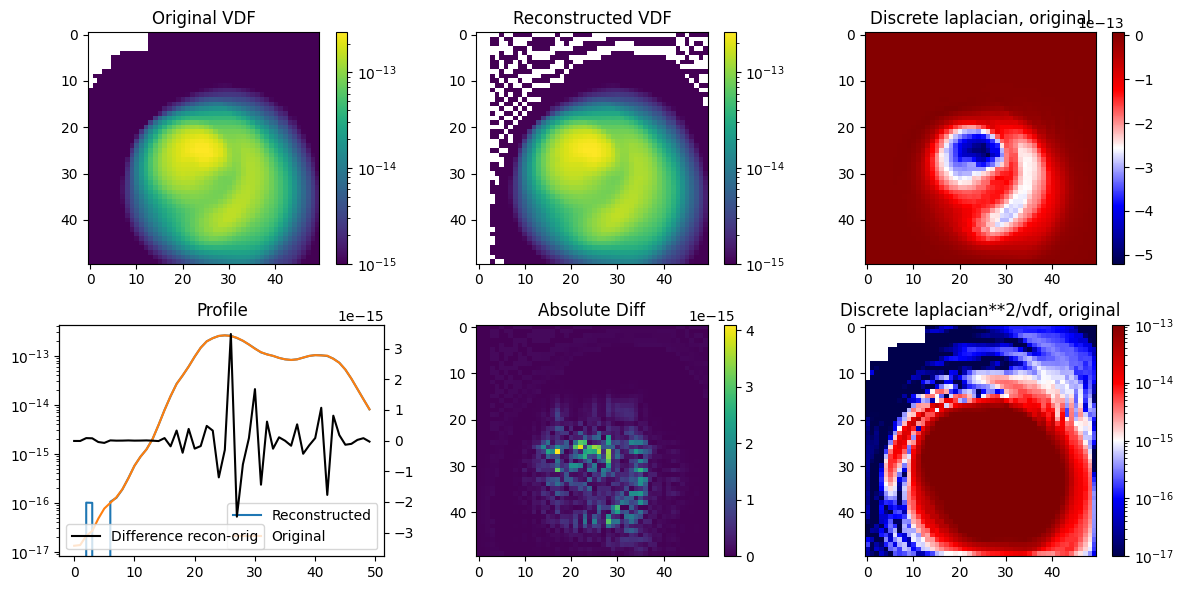

Moment Stats (R,Vm)= (0.031, 0.001) %.
L1,L2 rNorms= (0.006, 0.007).


In [69]:
project_tools.plot_vdfs(vdf, recon)
project_tools.print_comparison_stats(vdf,recon)